<a href="https://colab.research.google.com/github/curiosity806/2020_dacon_satellite_precipitation/blob/master/Dacon_satellite_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Conv2DTranspose, MaxPooling2D, BatchNormalization, Activation, concatenate, Input, GlobalAveragePooling2D
from tensorflow.keras import Model
import warnings
import gc
 
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
tf.__version__

'2.2.0-rc3'

## 데이터 불러오기

In [0]:
# 구글 드라이브에서 데이터 파일 받아오기
# 시각화를 위한 것이므로 우선 1개의 파트만 받아오기
train_p0 = np.load('/content/drive/My Drive/2020 Kaggle Study/data/train/train_p0.npy')

In [0]:
# 테스트 데이터 받아오기
test = np.load('/content/drive/My Drive/2020 Kaggle Study/data/test.npy')

In [0]:
# 재생산성을 위해 시드 고정
np.random.seed(7)
random.seed(7)
tf.random.set_seed(7)

In [36]:
# 훈련에서 사용하는 0~8번 채널만을 뽑아서 X_test에 저장하기
X_test = test[:,:,:,:9]
del test
gc.collect()

959

## 시각화 하기

In [0]:
import seaborn as sns

In [0]:
color_map = plt.cm.get_cmap('RdBu')
color_map = color_map.reversed()

In [0]:
image_sample = train_p0[0]

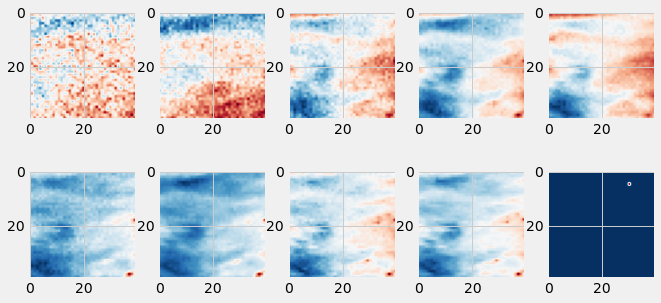

In [41]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 5))

for i in range(9):
    plt.subplot(2,5,i+1)
    plt.imshow(image_sample[:, :, i], cmap=color_map)

plt.subplot(2,5,10)
plt.imshow(image_sample[:,:,-1], cmap = color_map)
plt.show()

## 모델만들기

In [0]:
def build_model(input_layer, start_neurons):
    
    # 40 x 40 -> 20 x 20
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(pool1)
    pool1 = Dropout(0.25)(pool1)

    # 20 x 20 -> 10 x 10
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(pool2)
    pool2 = Dropout(0.25)(pool2)

    # 10 x 10 
    convm = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)

    # 10 x 10 -> 20 x 20
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.25)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)

    # 20 x 20 -> 40 x 40
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.25)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Dropout(0.25)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation='relu')(uconv1)
    
    return output_layer

input_layer = Input((40, 40, 9))
output_layer = build_model(input_layer, 32)

In [0]:
model = Model(input_layer, output_layer)

In [0]:
from sklearn.metrics import f1_score

def mae(y_true, y_pred) :
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    
    y_pred = y_pred.reshape(1, -1)[0]
    
    over_threshold = y_true >= 0.1
    
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

def fscore(y_true, y_pred):
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    
    y_pred = y_pred.reshape(1, -1)[0]
    
    remove_NAs = y_true >= 0
    
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    
    return(f1_score(y_true, y_pred))

def maeOverFscore(y_true, y_pred):
    
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

def fscore_keras(y_true, y_pred):
    score = tf.py_function(func=fscore, inp=[y_true, y_pred], Tout=tf.float32, name='fscore_keras')
    return score

def maeOverFscore_keras(y_true, y_pred):
    score = tf.py_function(func=maeOverFscore, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse') 
    return score

In [0]:
model.compile(loss="mae", optimizer="adam", metrics=[maeOverFscore_keras, fscore_keras])

## 데이터 제네레이터 만들기

In [0]:
data = train_p0
def trainGenerator():
    for file in data:
        target= file[:,:,-1].reshape(40,40,1)
        cutoff_labels = np.where(target < 0, 0, target)
        feature = file[:,:,:9]
        
        if (cutoff_labels > 0).sum() < 50:
            continue
        yield (feature, cutoff_labels)
        
train_dataset = tf.data.Dataset.from_generator(trainGenerator,
                                               (tf.float32, tf.float32),
                                               (tf.TensorShape([40,40,9]),
                                                tf.TensorShape([40,40,1])))
train_dataset = train_dataset.batch(512).prefetch(1)

## 모델 훈련하기
모델 훈련전에 GPU가 켜져있는지 확인!  
(런타임 -> 런타임 유형 변경-> 하드웨어 가속기-> GPU)

In [24]:
model_history = []

# 모든 데이터에 대해서 훈련할 것.
# 이미 메모리에 올라와 있는 train_p0를 메모리에서 제거
del train_p0
gc.collect()

# 5개로 분할된 데이터마다 각각 훈련을 진행
for i in range(5):
    data = np.load(f'/content/drive/My Drive/2020 Kaggle Study/data/train/train_p{i}.npy')
    train_dataset = tf.data.Dataset.from_generator(trainGenerator,
                                               (tf.float32, tf.float32),
                                               (tf.TensorShape([40,40,9]),
                                                tf.TensorShape([40,40,1])))
    train_dataset = train_dataset.batch(512).prefetch(1)
    history = model.fit(train_dataset, epochs = 5, verbose=1)
    #history = model.fit(train_dataset, epochs = 5, ,batch_size = 11, verbose=1)
    model_history.append(history)
    del data
    gc.collect()

Epoch 1/5
11/11 [==============================] - 8s 716ms/step - loss: 0.6314 - maeOverFscore_keras: 8.1242 - fscore_keras: 0.2425
Epoch 2/5
11/11 [==============================] - 7s 679ms/step - loss: 0.4331 - maeOverFscore_keras: 8.4212 - fscore_keras: 0.2360
Epoch 3/5
11/11 [==============================] - 7s 661ms/step - loss: 0.3708 - maeOverFscore_keras: 5.2907 - fscore_keras: 0.3582
Epoch 4/5
11/11 [==============================] - 7s 622ms/step - loss: 0.3162 - maeOverFscore_keras: 3.8929 - fscore_keras: 0.4450
Epoch 5/5
11/11 [==============================] - 7s 591ms/step - loss: 0.2951 - maeOverFscore_keras: 3.6214 - fscore_keras: 0.4764
Epoch 1/5
13/13 [==============================] - 8s 645ms/step - loss: 0.3241 - maeOverFscore_keras: 3.7031 - fscore_keras: 0.5190
Epoch 2/5
13/13 [==============================] - 8s 618ms/step - loss: 0.3186 - maeOverFscore_keras: 3.4100 - fscore_keras: 0.5587
Epoch 3/5
13/13 [==============================] - 8s 617ms/step - lo

## submission 만들기

In [0]:
pred = model.predict(X_test)

In [0]:
submission = pd.read_csv('/content/drive/My Drive/2020 Kaggle Study/data/sample_submission.csv')

In [0]:
submission.iloc[:,1:] = pred.reshape(-1, 1600)

In [0]:
submission.to_csv('Dacon_baseline.csv', index = False)

In [0]:
# 제출파일 구글 드라이브에 올리기
!cp Dacon_baseline.csv '/content/drive/My Drive/2020 Kaggle Study/submission'